## Part 1: RNC and DNC Speech Analysis
* The RNC and DNC speeches are written with the intent to persuade an otherwise already persuaded audience.
    * For example, viewers of the RNC are typically republican: "More viewers tuned into Fox News to watch the final night of the Republican convention than any other TV network" (https://www.wsj.com/articles/rnc-ratings-final-night-draws-23-8-million-viewers-as-trump-accepts-nomination-11598652831)
* This analysis will include a classifier which will predict whether a test document is from a republican speaker or a democratic speaker. 
    * Goal: to see if the classifier will be able to recognize differences in the word choices of each group. Hypothesis: high accuracy. Also, see the top features.
* Additionally, I will include a model to see if the length of the speech, the length of the sentences, the TTR, etc. has any significance on predicting between republican and democratic speeches.

In [1]:
import pandas as pd
import nltk
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns        # seaborn graphical package
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

In [2]:
conv_speeches = pd.read_csv("/Users/emmatarcson/Documents/data_science/RhetoricalFactor-analysis/data_sample/convspeeches.csv")
conv_speeches = conv_speeches[['Aff','Speech']]
conv_speeches.Aff.value_counts()

R    30
D    21
Name: Aff, dtype: int64

In [4]:
banned = ['Republican', 'Democrat', 'Republicans', 'Democrats']
f = lambda x: ' '.join([item for item in x.split() if item not in banned])
conv_speeches["Speech2"] = conv_speeches["Speech"].apply(f)

In [26]:
conv_speeches.head()

,Aff,Speech,Speech2
0,D,Good evening and thank you to everyone here to...,Good evening and thank you to everyone here to...
1,D,"We climbed the impossible mountain, and right ...","We climbed the impossible mountain, and right ..."
2,D,"Hello, America. I'm Andrew Yang. You might kno...","Hello, America. I'm Andrew Yang. You might kno..."
3,D,Good evening everybody. As you've seen by now ...,Good evening everybody. As you've seen by now ...
4,D,Good evening. Our great nation is now living i...,Good evening. Our great nation is now living i...


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

x = conv_speeches.Speech2[:1000] 
y = conv_speeches.Aff[:1000]

tfidf_model = TfidfVectorizer()
svc_model = SVC()


pipe = Pipeline(steps=[('tfidf', tfidf_model), ('svc', svc_model)])

param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],        
    'tfidf__stop_words': ['english', None],
    'svc__C': [1E5],
    'svc__kernel' : ['linear'],
    'svc__gamma' : [1]
}                           

search = GridSearchCV(pipe, param_grid, n_jobs=3, cv=5) 
search.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=3,
             param_grid={'svc__C': [1, 100000.0, 10], 'svc__gamma': [1],
                         'svc__kernel': ['linear'], 'tfidf__max_df': [0.5, 1],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__stop_words': ['english', None]})

In [30]:
print('best parameters:', search.best_params_)     # best-performing parameter combo
print('best mean accuracy:', search.best_score_)

best parameters: {'svc__C': 100000.0, 'svc__gamma': 1, 'svc__kernel': 'linear', 'tfidf__max_df': 0.5, 'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}
best mean accuracy: 0.9218181818181819


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv_speeches['Speech2'], conv_speeches['Aff'], random_state=0,
                                  train_size=0.6) 

In [49]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english')

X_text_train = vectorizer.fit_transform(X_train)


In [50]:
X_text_test = vectorizer.transform(X_test)

In [51]:
from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1E5)  
svcmodel.fit(X_text_train, y_train)

SVC(C=100000.0, kernel='linear')

In [52]:
pred = svcmodel.predict(X_text_test)
print(y_test[:20])
print(pred[:20])

29    R
11    D
10    D
22    R
2     D
28    R
45    R
32    R
26    R
4     D
33    R
41    R
27    R
35    R
34    R
7     D
14    D
46    R
18    D
48    R
Name: Aff, dtype: object
['R' 'D' 'D' 'R' 'D' 'R' 'D' 'R' 'R' 'D' 'R' 'R' 'R' 'R' 'R' 'D' 'D' 'R'
 'D' 'R']


In [53]:
accuracy_score(y_test, pred)

0.9523809523809523

In [54]:
letsee = [x for x in pred if x == 'D']
len(letsee)

8

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


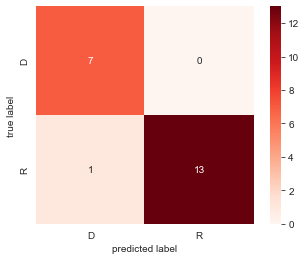

In [55]:
from sklearn.metrics import confusion_matrix
labels = ['D','R']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* So there is one instance of it guessing Democratic, instead of Republican in the test set. 
* this makes me wonder if there is some super significant word in these speeches that is causing this, but vvv
* That being said, I did expect a higher accuracy from the speeches

In [56]:
# because this is also just two binary, I can't do feature extraction, which is a bummer, but i'll add a random neutral 
# file just to see, not exactly pro data science, but

In [63]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
neutral = pd.DataFrame({'Aff' : 'None', 'Speech': '.'}, index=[1])
conv2 = conv_speeches[['Aff', 'Speech']]
conv2 = pd.concat([conv2, neutral])
conv2.tail()

,Aff,Speech
47,R,"Good evening. My name is Rudy Giuliani, and I'..."
48,R,I'm Tiffany Trump. Since speaking at the Repub...
49,R,Good evening. I'm Senator Tim Scott from the g...
50,R,Good evening. I'm Senator Tom Cotton. A lot's ...
1,None,.


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(conv2['Speech'], conv2['Aff'], random_state=0,
                                  train_size=0.6)
nbmodel = MultinomialNB()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,max_features=1500, stop_words='english') #using this to find vocab
X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


nbmodel.fit(X_text_train, y_train)
pred = nbmodel.predict(X_text_test)

def print_top(vectorizer, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
    

print_top(vectorizer, nbmodel, nbmodel.classes_, 60)

D: immigrants, doesn, protect, times, high, including, trust, justice, dream, economic, failed, injustice, empathy, beau, left, hope, small, plan, look, children, says, lead, loss, black, stand, government, heard, pandemic, movement, women, day, strong, rights, truth, win, poverty, promise, voting, say, knows, crisis, office, mail, text, states, seen, didn, harris, kids, virus, million, healthcare, covid, jobs, united, got, going, democracy, ll, kamala
None: forget, gone, goes, god, goal, globe, global, giving, gives, given, girl, going, fact, foreign, force, feels, feel, federal, fear, favorite, favored, father, fast, farmers, far, families, fall, fake, faith, fairness, fair, failure, failed, facts, fellow, felt, fields, fierce, food, follow, folks, focus, floyd, florida, flew, flag, fixed, forced, firsthand, finish, fine, finds, finding, financial, finally, final, filled, fighting, fired, zones
R: pandemic, coming, means, reform, single, election, bless, isis, important, drug, law, c

In [71]:
dem = conv_speeches[conv_speeches.Aff == 'D'].Speech
rep = conv_speeches[conv_speeches.Aff == 'R'].Speech

demfull = str(list(dem.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''")
repfull = str(list(rep.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''")

In [72]:
rep_speech = nltk.sent_tokenize(repfull)
rep_speech2 = pd.DataFrame({'Aff':'R',
                         'Sent': rep_speech})
dem_speech = nltk.sent_tokenize(demfull)
dem_speech2 = pd.DataFrame({'Aff':'D',
                         'Sent': dem_speech})
aff_sent = pd.concat([rep_speech2,dem_speech2])
aff_sent

,Aff,Sent
0,R,"""I'm Ben Carson, a retired neurosurgeon and a ..."
1,R,"Before I begin, I'd like to say that our heart..."
2,R,"As Jacob's mother has urged the country, let's..."
3,R,America is great when we behave greatly.
4,R,"In order to succeed and change, we must first ..."
...,...,...
1094,D,"Here's the truth, Donald Trump doesn't want an..."
1095,D,So whether you plan to vote by mail or in pers...
1096,D,Don't let Donald Trump take that away from you.
1097,D,"For accurate, up to date voting information th..."


In [82]:
aff_sent.Aff.value_counts()

R    2709
D    1099
Name: Aff, dtype: int64

In [83]:
just_R = aff_sent[aff_sent.Aff == 'R']
just_R = just_R[:1099]
just_D = aff_sent[aff_sent.Aff == 'D']
aff_sent = pd.concat([just_R, just_D])
aff_sent.Aff.value_counts()

R    1099
D    1099
Name: Aff, dtype: int64

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(aff_sent['Sent'], aff_sent['Aff'], random_state=0,
                                  train_size=0.6) 
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english')

X_text_train = vectorizer.fit_transform(X_train)
X_text_test = vectorizer.transform(X_test)


In [85]:
from sklearn.svm import SVC 
svcmodel = SVC(kernel='linear', C=1)  
svcmodel.fit(X_text_train, y_train)
pred = svcmodel.predict(X_text_test)
accuracy_score(y_test, pred)

0.7363636363636363

/Users/emmatarcson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'R'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


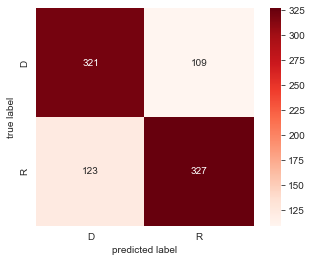

In [86]:
from sklearn.metrics import confusion_matrix
labels = ['D','R']
mat = confusion_matrix(y_test, pred, labels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
           xticklabels=labels, yticklabels=labels)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [216]:
# so onto extra features

import re
trans_toks = [nltk.word_tokenize(re.sub(r'[^\w+ ]', '', t.lower())) for t in conv_speeches['Speech']]
trans_tok_lens = [len(t) for t in trans_toks]
trans_type_lens = [len(set(t)) for t in trans_toks]
TTR = [len(set(t))/len(t) for t in trans_toks]

conv_speeches['Toks'] = trans_toks
conv_speeches['Token_count'] = trans_tok_lens
conv_speeches['Type_count'] = trans_type_lens
conv_speeches['TTR'] = TTR
conv_speeches.head()

,Aff,Speech,Toks,Token_count,Type_count,TTR
0,D,Good evening and thank you to everyone here to...,"[good, evening, and, thank, you, to, everyone,...",193,118,0.611399
1,D,"We climbed the impossible mountain, and right ...","[we, climbed, the, impossible, mountain, and, ...",750,326,0.434667
2,D,"Hello, America. I'm Andrew Yang. You might kno...","[hello, america, im, andrew, yang, you, might,...",428,214,0.500000
3,D,Good evening everybody. As you've seen by now ...,"[good, evening, everybody, as, youve, seen, by...",2278,795,0.348990
4,D,Good evening. Our great nation is now living i...,"[good, evening, our, great, nation, is, now, l...",982,440,0.448065


There could be some information to see if a classifier would be able to predict based on token length, but since these are pre written speeches, and I can't do feature extraction at the moment, maybe TTR will be useful to look at. 

In [222]:
sents = [len(nltk.sent_tokenize(t)) for t in conv_speeches['Speech']]

conv_speeches['SentAmt'] = sents
conv_speeches['AVGSENTLEN'] = conv_speeches.Token_count/conv_speeches.SentAmt
conv_speeches.head()

,Aff,Speech,Toks,Token_count,Type_count,TTR,SentAmt,AVGSENTLEN
0,D,Good evening and thank you to everyone here to...,"[good, evening, and, thank, you, to, everyone,...",193,118,0.611399,5,38.600000
1,D,"We climbed the impossible mountain, and right ...","[we, climbed, the, impossible, mountain, and, ...",750,326,0.434667,55,13.636364
2,D,"Hello, America. I'm Andrew Yang. You might kno...","[hello, america, im, andrew, yang, you, might,...",428,214,0.500000,25,17.120000
3,D,Good evening everybody. As you've seen by now ...,"[good, evening, everybody, as, youve, seen, by...",2278,795,0.348990,102,22.333333
4,D,Good evening. Our great nation is now living i...,"[good, evening, our, great, nation, is, now, l...",982,440,0.448065,44,22.318182


In [243]:
# building logistic regression
from sklearn.linear_model import LogisticRegression 
X = conv_speeches[['Token_count', 'Type_count', 'TTR', 'SentAmt', 'AVGSENTLEN']]
y = conv_speeches['Aff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


lr_model = LogisticRegression(C = 1, class_weight= None, penalty='l2')   # default setting
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred) 


0.45454545454545453

Interesting, so for speeches, the svc classifier was almost 100% positive about the Affiliation, but the format of the speeches didn't play a big role. This might actually help my hypothesis in that speeches were more directed at known audience and so they were more polarizing, but the actually makings of the speeches were not as distinguishable.

### Exploration, please ignore for now

In [228]:
# possible topic modeling for looking at what both groups were talking about? 

In [200]:
# this is a mess
just_D = conv_speeches[conv_speeches.Aff == 'D'].Speech
just_R = conv_speeches[conv_speeches.Aff == 'R'].Speech
D_full = pd.DataFrame({'Aff': 'D', 'Speech' : str(list(just_D.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''")},
                      index = [1])
R_full = pd.DataFrame({'Aff': 'R', 'Speech' : str(list(just_R.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''")},
                      index = [2])
D_and_R = pd.concat([R_full, D_full])
D_list = [('D', str(list(just_D.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''"))]
R_list = ('R', str(list(just_R.values)).replace("',", '.').replace(" '"," ").strip('[]').strip("''"))
D_list.append(R_list)

In [202]:
# like in the debate analysis, there's no way to figure out a binary word importance :(
# maybe I can find just the most frequent words used in each and compare them?
import re

# i tried getting rid of stop words using nltk, but that didn't work so I manually got rid of some
#words = nltk.word_tokenize(re.sub(r'[^\w ]', '', 
#word_features = nltk.FreqDist(t.lower() for t in nltk.word_tokenize(full))
#def document_features(document): 
   # document_words = set(document) 
   # features = {}
   # for word in word_features:
    #    features['contains({})'.format(word)] = (word in document_words)
   # return features

In [203]:
#featuresets = [(a, document_features(b)) for (a,b) in D_list]
#train_set, test_set = featuresets[100:], featuresets[:100]
#classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
#print(nltk.classify.accuracy(classifier, test_set))